# Tutorial: Data as Objects
In this tutorial, we'll talk about how to use "model objects" in R. 

## Goals:
* Learn how to interact with model objects in R including extracting coefficients
* Learn how to use the `nest()` function
* Learn how to use the `map()` function

---
# Interacting with model objects in R

Whenever you run a regression or any other type of model, the resulting model is saved in an object with properties you can access. This is handy for fitting a model once, and then referencing different aspects of that model's performance and fit. Let's see an example:

In [4]:
library(tidyverse)

# generate data where y is a function of two variables, x1 and x2
x1 <- seq(-4,4,0.5) #generate data ranging from -4 to 4 in steps of 0.5
x2 <- seq(-4,4,0.5)
#specify a sigmoidal relationship between x1 and y 
#and a linear relationship between x2 and y
dat <- expand.grid(x1=x1, x2=x2) %>% 
    mutate(y = 1/(1+exp(-x1)) + 0.1*x2)

head(dat)

,x1,x2,y
,<dbl>,<dbl>,<dbl>
1,-4.0,-4,-0.3820138
2,-3.5,-4,-0.3706878
3,-3.0,-4,-0.3525741
4,-2.5,-4,-0.3241418
5,-2.0,-4,-0.2807971
6,-1.5,-4,-0.2175745


(Note that `expand.grid` just creates a data frame with all possible pairs of the input variables. So here, each value of `x1` was paired with an `x2` value of -4, then with an `x2` value of -3.5, etc...)

Here is how y depends on x1 and x2:

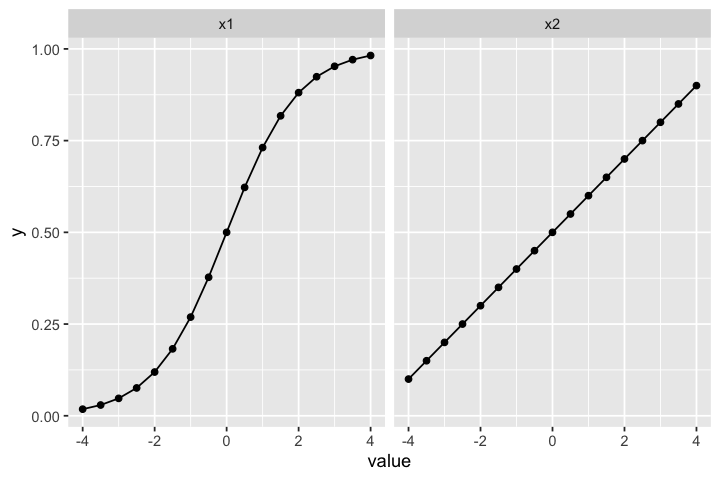

In [7]:
# setting figure size
options(repr.plot.width=6, repr.plot.height=4)

dat  %>%
    gather(var, value, x1, x2) %>% # make it long format - only x1 or x2 in each row
    ggplot(aes(value, y)) +
    stat_summary(geom='point',fun=mean) +
    stat_summary(geom='line',fun=mean) +
    facet_wrap(~var)


Now, let's add some noise and try to fit a regression model

In [8]:
#create new y_obs variable with normally distributed noise
dat <- mutate(dat, y_obs = y + rnorm(length(y), mean=0, sd=0.1)) 

#fit a linear model to find the regression coefficients
model_fit <- lm(y_obs ~ x1 + x2, data=dat) 

The resulting model is saved in the `model_fit` variable. This is the "model object", and you can do a number of things with it. First, the `str` command, which is a general function for printing the structure of r objects, will tell you what you can find in the model object. As you can see below, it is a list of different variables, which you can access by typing the name of the model, followed by `$variable`.

In [ ]:
str(model_fit) #print the structure of the model object

List of 12
 $ coefficients : Named num [1:3] 0.49 0.145 0.103
  ..- attr(*, "names")= chr [1:3] "(Intercept)" "x1" "x2"
 $ residuals    : Named num [1:289] 0.161087 -0.000838 -0.047814 0.060155 -0.099688 ...
  ..- attr(*, "names")= chr [1:289] "1" "2" "3" "4" ...
 $ effects      : Named num [1:289] -8.3291 6.0409 4.283 0.0562 -0.1037 ...
  ..- attr(*, "names")= chr [1:289] "(Intercept)" "x1" "x2" "" ...
 $ rank         : int 3
 $ fitted.values: Named num [1:289] -0.502 -0.429 -0.357 -0.284 -0.212 ...
  ..- attr(*, "names")= chr [1:289] "1" "2" "3" "4" ...
 $ assign       : int [1:3] 0 1 2
 $ qr           :List of 5
  ..$ qr   : num [1:289, 1:3] -17 0.0588 0.0588 0.0588 0.0588 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:289] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:3] "(Intercept)" "x1" "x2"
  .. ..- attr(*, "assign")= int [1:3] 0 1 2
  ..$ qraux: num [1:3] 1.06 1.08 1.09
  ..$ pivot: int [1:3] 1 2 3
  ..$ tol  : num 1e-07
  ..$ rank : int 3
  ..- attr(*, "class")= c

For example, if we want to extract the estimated regression coefficients, we can type this, which returns a named vector.

In [ ]:
model_fit$coefficients

(Intercept)          x1          x2 
 0.50322978  0.14768216  0.09798459

If we run multiple models, we might want to store these values in a data.frame, rather than a named vector like this:

In [9]:
#store the coefficients in a variable
coef <- model_fit$coefficients 

#save the name/value of the coefficients in a dataframe
data.frame(name = names(coef), value = coef) 

,name,value
,<chr>,<dbl>
(Intercept),(Intercept),0.50808129
x1,x1,0.14541006
x2,x2,0.09802597


You can extract the prediction of the model. They are stored under `$fitted.values`, or you can also get them by typing `fitted(model_fit)`, which returns the same values. Then, we can plot the observed values against the predicted values:

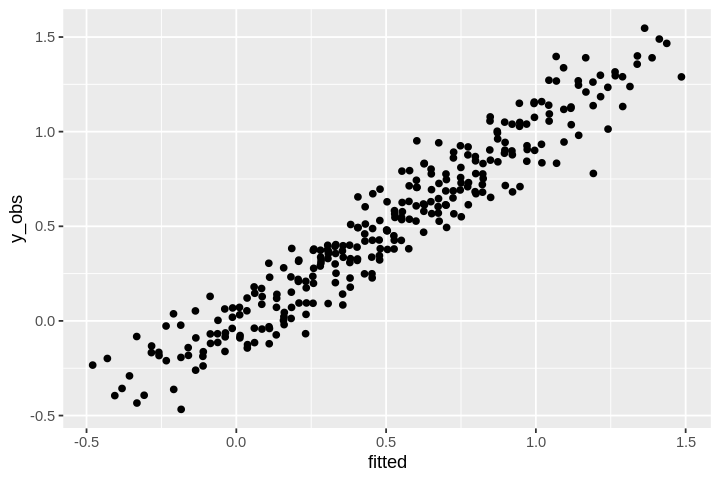

In [ ]:
#extract model estimate of y for each x and store in df as fitted
dat$fitted <- model_fit$fitted.values 

#plot against the observed data 
ggplot(dat, aes(fitted, y_obs)) + 
    stat_summary(geom='point',fun=mean)

In [ ]:
head(dat) #dataframe for fitted and obs. values. 

,x1,x2,y,y_obs,fitted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-4.0,-4,-0.3820138,-0.2334409,-0.4794372
2,-3.5,-4,-0.3706878,-0.3947202,-0.4055961
3,-3.0,-4,-0.3525741,-0.4338976,-0.3317550
4,-2.5,-4,-0.3241418,-0.1831898,-0.2579140
5,-2.0,-4,-0.2807971,-0.4672971,-0.1840729
6,-1.5,-4,-0.2175745,-0.1628049,-0.1102318


Given your fitted model, you can also easily generate predictions of y given new values of x using the `predict` function: 

In [ ]:
new_data <- data.frame(x1=-5, x2=10) #new x-values to give to the model 
predict(model_fit, newdata = new_data) #predict the y value for a given x 

1 
0.7446649

This is where the fun part comes in. You can use the `nest` and `map` commands from `tidyverse` to fit a model for different subgroups, then extract the results of all models. Let's pretend that x1 is the participant number and we have different subjects, for which we have y and x2 values.

First, nest creates a nested data.frame, in which the data.frame for each group is stored in a different cell

In [49]:
dat  <- dat  %>%
        group_by(x1) %>%
        nest()

print(dat)

# A tibble: 17 × 2
# Groups:   x1 [17]
      x1 data             
   <dbl> <list>           
 1  -4   <tibble [17 × 3]>
 2  -3.5 <tibble [17 × 3]>
 3  -3   <tibble [17 × 3]>
 4  -2.5 <tibble [17 × 3]>
 5  -2   <tibble [17 × 3]>
 6  -1.5 <tibble [17 × 3]>
 7  -1   <tibble [17 × 3]>
 8  -0.5 <tibble [17 × 3]>
 9   0   <tibble [17 × 3]>
10   0.5 <tibble [17 × 3]>
11   1   <tibble [17 × 3]>
12   1.5 <tibble [17 × 3]>
13   2   <tibble [17 × 3]>
14   2.5 <tibble [17 × 3]>
15   3   <tibble [17 × 3]>
16   3.5 <tibble [17 × 3]>
17   4   <tibble [17 × 3]>


What we see here is that each "participant" has their own 17 x 3 tibble. Why these dimensions? We simulated `x1` and `x2` to be identical, both 17 observations long. The 3 columns are for `x2`, `y`, and `y_obs`. They are just now grouped by `x1`.

Remember, we want to fit models to each subgroup. The `map` function applies a given function to a set of data in an iterative way -- so this would be a convenient approach. Some of the benefits of using `map` are that you do not have to write a series of for-loops (it's efficient/vectorized) and it makes your code easier to read (and thus error check). Now you can use `map` to fit a model to each subgroup like this:

In [51]:
dat  <- dat  %>% 
    mutate(model_fit = map(data,
                           function(data) lm(y_obs ~ x2, data=data)))

print(dat)

# A tibble: 17 × 3
# Groups:   x1 [17]
      x1 data              model_fit
   <dbl> <list>            <list>   
 1  -4   <tibble [17 × 3]> <lm>     
 2  -3.5 <tibble [17 × 3]> <lm>     
 3  -3   <tibble [17 × 3]> <lm>     
 4  -2.5 <tibble [17 × 3]> <lm>     
 5  -2   <tibble [17 × 3]> <lm>     
 6  -1.5 <tibble [17 × 3]> <lm>     
 7  -1   <tibble [17 × 3]> <lm>     
 8  -0.5 <tibble [17 × 3]> <lm>     
 9   0   <tibble [17 × 3]> <lm>     
10   0.5 <tibble [17 × 3]> <lm>     
11   1   <tibble [17 × 3]> <lm>     
12   1.5 <tibble [17 × 3]> <lm>     
13   2   <tibble [17 × 3]> <lm>     
14   2.5 <tibble [17 × 3]> <lm>     
15   3   <tibble [17 × 3]> <lm>     
16   3.5 <tibble [17 × 3]> <lm>     
17   4   <tibble [17 × 3]> <lm>     


Let's break down what is going on in the `mutate` line above:
* `model_fit` is the name of our new column
* The first argument of `map` is what we want our function to iterate over. In this case, `data` is the name of the column of our nested tibbles.
* The second argument of `map` is whatever function you want performed. Here, we specified our own function (a linear model), but you could also use built-in functions.

So basically, for each observation of `data`, `map` will perform the function. It's just that in this case, a single observation of `data` is an entire tibble. 

(Note that `map` operates basically the same as the `*apply` family of functions (e.g., `lapply()`, `sapply`, etc.) but since `map` is part of the tidyverse, it plays better with tidyverse grammar and is more standardized.)

Our resulting models are stored in each cell of the model_fit column. Let's see what's included in a single cell in this column:

In [52]:
dat[1, "model_fit"]

model_fit
<list>
"-0.02660423, 0.103168, -0.1372348, 0.03059727, -0.02660468, 0.08687411, 0.1791387, -0.2292829, 0.06875712, -0.1114032, 0.09896134, -0.01441061, 0.1396485, 0.1815616, -0.1479196, -0.07825647, 0.02050686, 0.01632427, -0.07725744, 0.1096921, 1.041945, -0.009751889, 0.1059652, 0.2004681, -0.2057152, 0.09456317, -0.08335881, 0.129244, 0.01811038, 0.1744078, 0.2185592, -0.1086836, -0.03678222, 0.06421942, 0.06227515, -0.02906825, 2, -0.4392761, -0.3876921, -0.3361081, -0.2845241, -0.2329402, -0.1813562, -0.1297722, -0.07818821, -0.02660423, 0.02497975, 0.07656373, 0.1281477, 0.1797317, 0.2313157, 0.2828997, 0.3344836, 0.3860676, 0, 1, -4.123106, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 0.2425356, 1.776357e-15, 10.0995, 0.2197359, 0.1702285, 0.1207211, 0.07121375, 0.02170637, -0.02780101, -0.07730838, -0.1268158, -0.1763231, -0.2258305, -0.2753379, -0.3248453, -0.3743526, -0.42386, -0.4733674, 1.242536, 1.269243, 1, 2, 1e-07, 2, 15, lm(formula = y_obs ~ x2, data = data), y_obs ~ x2, -0.5765109, -0.3570948, -0.3627128, -0.19765, -0.05380143, -0.4106391, -0.06101507, -0.1895914, 0.07235711, 0.01056914, 0.2162122, 0.3097093, 0.03181212, 0.1530592, 0.3034065, 0.3508079, 0.3088102, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4"


Super ugly, but this is the actual model fit information for our first row. 

It's much easier to extract the information you need from each model. Let's extract the coefficients:

In [55]:
dat <- dat  %>% 
        mutate(coef = map(model_fit, #now iterating over "model_fit" instead of "data"
                      #a function to create data frame of coef names/values:
                      function(fit) data.frame(name = names(fit$coefficients), 
                                               beta = fit$coefficients)))
print(dat)

# A tibble: 17 × 4
# Groups:   x1 [17]
      x1 data              model_fit coef        
   <dbl> <list>            <list>    <list>      
 1  -4   <tibble [17 × 3]> <lm>      <df [2 × 2]>
 2  -3.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
 3  -3   <tibble [17 × 3]> <lm>      <df [2 × 2]>
 4  -2.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
 5  -2   <tibble [17 × 3]> <lm>      <df [2 × 2]>
 6  -1.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
 7  -1   <tibble [17 × 3]> <lm>      <df [2 × 2]>
 8  -0.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
 9   0   <tibble [17 × 3]> <lm>      <df [2 × 2]>
10   0.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
11   1   <tibble [17 × 3]> <lm>      <df [2 × 2]>
12   1.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
13   2   <tibble [17 × 3]> <lm>      <df [2 × 2]>
14   2.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
15   3   <tibble [17 × 3]> <lm>      <df [2 × 2]>
16   3.5 <tibble [17 × 3]> <lm>      <df [2 × 2]>
17   4   <tibble [17 × 3]> <lm>      <df [2 × 2]>


They are again stored in a column called coef that holds a data frame in each cell. If you want to then finally just get a data.frame with coefficients, you can unnest the results:

In [56]:
dat  <- dat  %>% 
        unnest(coef)

print(dat)

# A tibble: 34 × 5
# Groups:   x1 [17]
      x1 data              model_fit name           beta
   <dbl> <list>            <list>    <chr>         <dbl>
 1  -4   <tibble [17 × 3]> <lm>      (Intercept) -0.0266
 2  -4   <tibble [17 × 3]> <lm>      x2           0.103 
 3  -3.5 <tibble [17 × 3]> <lm>      (Intercept)  0.0336
 4  -3.5 <tibble [17 × 3]> <lm>      x2           0.0900
 5  -3   <tibble [17 × 3]> <lm>      (Intercept)  0.103 
 6  -3   <tibble [17 × 3]> <lm>      x2           0.104 
 7  -2.5 <tibble [17 × 3]> <lm>      (Intercept)  0.0975
 8  -2.5 <tibble [17 × 3]> <lm>      x2           0.0883
 9  -2   <tibble [17 × 3]> <lm>      (Intercept)  0.0941
10  -2   <tibble [17 × 3]> <lm>      x2           0.0944
# … with 24 more rows


You can find additional information on this approach here: http://omaymas.github.io/Climate_Change_ExpAnalysis/

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, Amy Sentis, and Fiona Horner.*